# Step by Step OCR
This notebook contains all steps of OCR

In [12]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2

sys.path.append('../src')
from ocr.normalization import word_normalization, letter_normalization
from ocr import page,words,characters
from ocr.helpers import implt, resize
from ocr.tfhelpers import Model
from ocr.datahelpers import idx2char

Loading segmentation models...
INFO:tensorflow:Restoring parameters from C:\Users\debashish mishra\major_project_v3\handwriting-ocr-master\src\ocr\../../models/gap-clas/CNN-CG
INFO:tensorflow:Restoring parameters from C:\Users\debashish mishra\major_project_v3\handwriting-ocr-master\src\ocr\../../models/gap-clas/RNN/Bi-RNN-new


In [4]:
!pip install unidecode

In [13]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

### Global Variables

In [30]:
IMG = '../data/pages/test3.jpg'    # 1, 2, 3
LANG = 'en'
# You can use only one of these two
# You HABE TO train the CTC model by yourself using word_classifier_CTC.ipynb
MODEL_LOC_CHARS = '../models/char-clas/' + LANG + '/CharClassifier'
MODEL_LOC_CTC = '../models/word-clas/CTC/Classifier1'

## Load Trained Model

In [31]:
CHARACTER_MODEL = Model(MODEL_LOC_CHARS)
CTC_MODEL = Model(MODEL_LOC_CTC, 'word_prediction')

INFO:tensorflow:Restoring parameters from ../models/char-clas/en/CharClassifier
INFO:tensorflow:Restoring parameters from ../models/word-clas/CTC/Classifier1


## Load image

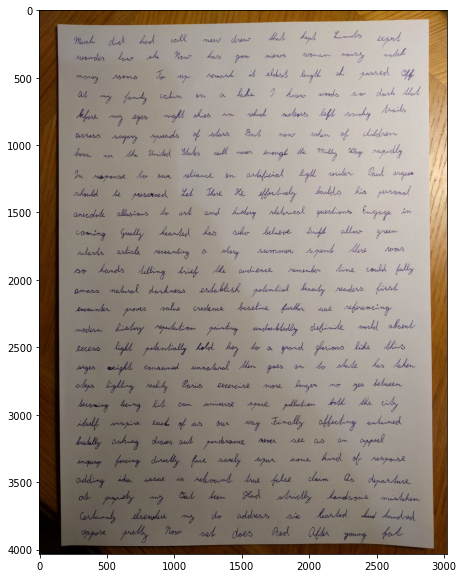

In [33]:
image = cv2.cvtColor(cv2.imread(IMG), cv2.COLOR_BGR2RGB)
implt(image)

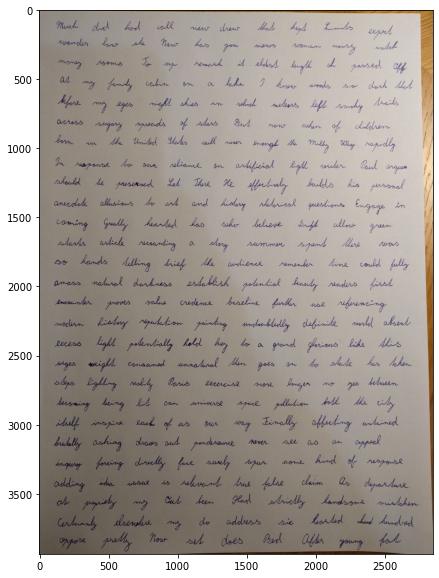

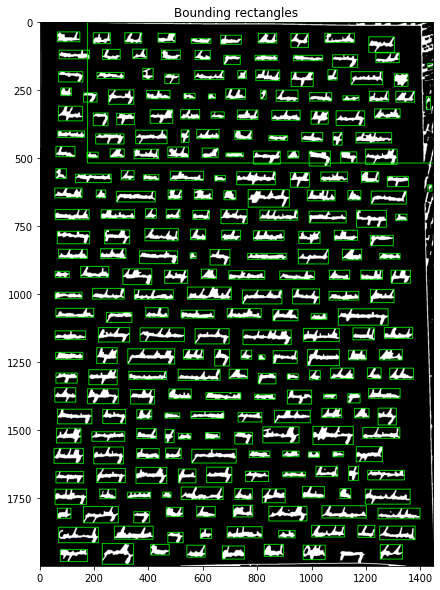

In [34]:
# Crop image and get bounding boxes
crop = page.detection(image)
implt(crop)
boxes = words.detection(crop)
lines = words.sort_words(boxes)

# Recognition Using Character + Separator Model

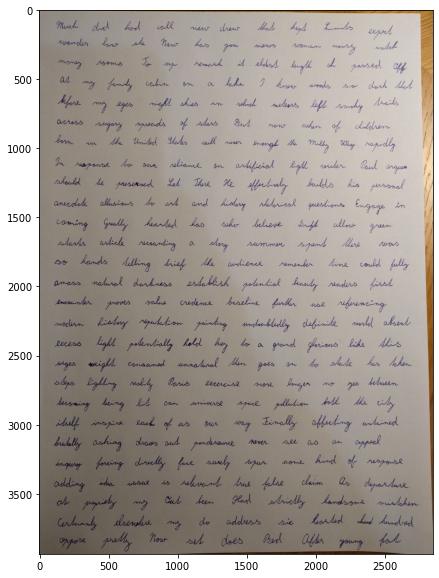

In [35]:
def recognise(img):
    """Recognition using character model"""
    # Pre-processing the word
    img = word_normalization(
        img,
        60,
        border=False,
        tilt=True,
        hyst_norm=True)

    # Separate letters
    img = cv2.copyMakeBorder(
        img,
        0, 0, 30, 30,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0])
    gaps = characters.segment(img, RNN=True)

    chars = []
    for i in range(len(gaps)-1):
        char = img[:, gaps[i]:gaps[i+1]]
        char, dim = letter_normalization(char, is_thresh=True, dim=True)
        # TODO Test different values
        if dim[0] > 4 and dim[1] > 4:
            chars.append(char.flatten())

    chars = np.array(chars)
    word = ''        
    if len(chars) != 0:
        pred = CHARACTER_MODEL.run(chars)                
        for c in pred:
            word += idx2char(c)

    return word

implt(crop)
with open('major.txt', 'w') as f:
    
    for line in lines:
        k=(" ".join([recognise(crop[y1:y2, x1:x2]) for (x1, y1, x2, y2) in line]))
        f.write(k)
        f.write('\n')
f.close()

#
        

# Recognition Using CTC Model

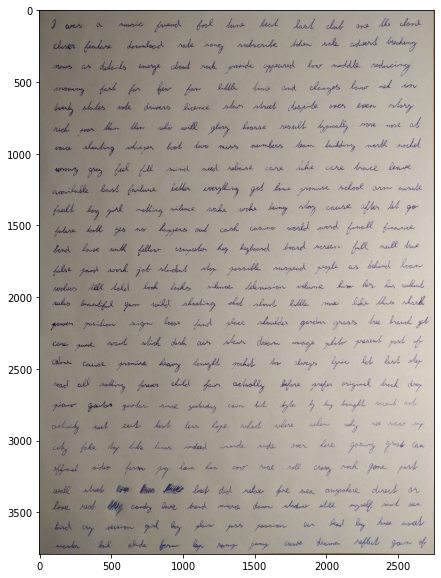

[array([ 83,  60, 119, 134], dtype=int64), array([180,  90, 301, 138], dtype=int64), array([397,  87, 447, 123], dtype=int64), array([553,  79, 729, 121], dtype=int64), array([801,  64, 994, 159], dtype=int64), array([1093,   56, 1216,  144], dtype=int64), array([1298,   54, 1442,  128], dtype=int64), array([1531,   58, 1669,  123], dtype=int64), array([1769,   56, 1925,  136], dtype=int64), array([1999,   60, 2124,  140], dtype=int64), array([2207,   94, 2302,  132], dtype=int64), array([2364,   53, 2450,  121], dtype=int64), array([2510,   53, 2666,  115], dtype=int64)]
[array([ 96, 208, 257, 278], dtype=int64), array([310, 202, 507, 299], dtype=int64), array([612, 210, 871, 276], dtype=int64), array([ 960,  197, 1083,  267], dtype=int64), array([1146,  231, 1286,  306], dtype=int64), array([1377,  202, 1667,  265], dtype=int64), array([1749,  198, 1904,  263], dtype=int64), array([1965,  191, 2092,  255], dtype=int64), array([2165,  181, 2364,  259], dtype=int64), array([2412,  181,

In [22]:
def recognise(img):
    """Recognising words using CTC Model."""
    img = word_normalization(
        img,
        64,
        border=False,
        tilt=False,
        hyst_norm=False)
    length = img.shape[1]
    # Input has shape [batch_size, height, width, 1]
    input_imgs = np.zeros(
            (1, 64, length, 1), dtype=np.uint8)
    input_imgs[0][:, :length, 0] = img

    pred = CTC_MODEL.eval_feed({
        'inputs:0': input_imgs,
        'inputs_length:0': [length],
        'keep_prob:0': 1})[0]

    word = ''
    for i in pred:
        word += idx2char(i)
    return word

implt(crop)
for line in lines:
    #print(" ".join([recognise(crop[y1:y2, x1:x2]) for (x1, y1, x2, y2) in line]))
    print(line)
